# 基于TimesNet的说话人识别算法

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
import os
import re
import torch
import torchaudio
from torchaudio.transforms import MFCC
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

## 基础知识

### 梅尔频率倒谱系数

MFCC（Mel Frequency Cepstral Coefficients，梅尔频率倒谱系数）是语音信号处理中常用的一种特征提取方法，广泛应用于语音识别、音频处理等领域。MFCC的目的是将音频信号转换为一个更适合机器学习模型处理的特征表示。

MFCC的基本步骤：
- 分帧（Framing）：将音频信号分割成多个小的时间片段，每个片段通常为20-40毫秒。这是因为语音信号在短时间内可以近似为平稳信号。

- 窗口加权（Windowing）：对每一帧信号应用窗函数（通常是汉明窗或汉宁窗），以减小帧之间的边界效应。

- 快速傅里叶变换（FFT）：对每一帧信号进行FFT变换，得到信号的频谱表示。

- Mel频率滤波器组：将频谱经过Mel频率尺度的滤波器组进行滤波。Mel尺度是一种对人耳听觉特性的模拟，它在低频段具有更高的分辨率，而在高频段分辨率较低。

- 对数变换：对滤波器输出的能量进行对数变换，这一操作是为了模拟人耳对声音强度的感知。

- 离散余弦变换（DCT）：对经过Mel频率滤波后的能量谱进行离散余弦变换，最终得到MFCC系数。

### MFCC

构造函数：MFCC:
- sample_rate（int）：音频的采样率。通常音频文件的采样率为16000、22050、44100等，这会影响特征提取的精度和速度。

- n_mfcc（int）：要提取的MFCC系数的数量。通常选择13个MFCC系数，这些系数能够有效捕捉音频信号的特征。n_mfcc的默认值是13。

- melkwargs（dict，可选）：一个字典，包含Mel滤波器组的参数配置。常见的参数包括：

    - n_fft: 用于计算FFT的窗口大小（以样本为单位），默认值通常是400。
    - hop_length: 每一帧的步长（以样本为单位），默认值通常是160。
    - n_mels: Mel滤波器的数量，决定了Mel频率尺度的分辨率。默认通常为23。
    - center: 是否将FFT窗口居中，默认为True。

forward方法是MFCC类的核心功能，它执行音频信号的MFCC特征提取过程。调用transform(waveform)时，实际上是调用forward方法。
- waveform（Tensor）：一个形状为 (channel, time) 的音频波形张量。通常情况下，channel表示音频的声道数（单声道是1，立体声是2），time表示音频的样本数。

- 返回值：一个形状为 (n_mfcc, time) 的张量，包含了提取的MFCC系数。n_mfcc是MFCC系数的数量，time是帧数（即音频信号的时长被分割成的小帧数量，**每帧代表每个时间步**）。

### 举例说明

In [55]:
import torch
import torchaudio
from torchaudio.transforms import MFCC

# 读取立体声音频（2通道）
waveform, sample_rate = torchaudio.load('../data\\cyy1.wav')

# 设置MFCC转换器
mfcc_transform = MFCC(
    sample_rate=sample_rate,
    n_mfcc=13,
    melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 23, 'center': False}
)

# 处理左右声道
mfcc_left = mfcc_transform(waveform[0])  # 左声道
mfcc_right = mfcc_transform(waveform[1])  # 右声道

# 你可以将它们分别输入模型
print(mfcc_left.shape, mfcc_right.shape)

torch.Size([13, 9981]) torch.Size([13, 9981])


In [57]:
waveform[0].size()

torch.Size([1597200])

## 数据预处理

### 分帧

#### 计算帧数

In [2]:
# 计算帧数
def Nf(wave_data):
    wlen = 3840
    inc = 960  #每帧长度20ms
    signal_length = len(wave_data)  #信号总长度
    if signal_length <= wlen:  #若信号长度小于一个帧的长度，则帧数定义为1
        nf = 1
    else:  #否则，计算帧的总长度
        nf = int(np.ceil((1.0 * signal_length - wlen + inc) / inc))
    return nf

#### 信号分帧

In [3]:
# 信号分帧
def Frame(wave_data, nf):
    wlen = 3840
    inc = 960  #每帧长度20ms
    signal_length = len(wave_data)  #信号总长度
    if signal_length <= wlen:  #若信号长度小于一个帧的长度，则帧数定义为1
        nf = 1
    else:  #否则，计算帧的总长度
        nf = int(np.ceil((1.0 * signal_length - wlen + inc) / inc))
    pad_length = int((nf - 1) * inc + wlen)  #所有帧加起来总的铺平后的长度
    zeros = np.zeros(
        (pad_length - signal_length, ))  #不够的长度使用0填补，类似于FFT中的扩充数组操作
    pad_signal = np.concatenate((wave_data, zeros))  #填补后的信号记为pad_signal
    indices = np.tile(np.arange(0, wlen), (nf, 1)) + np.tile(
        np.arange(0, nf * inc, inc),
        (wlen, 1)).T  #相当于对所有帧的时间点进行抽取，得到nf*nw长度的矩阵
    indices = np.array(indices, dtype=np.int32)  #将indices转化为矩阵
    frames = pad_signal[indices]  #得到帧信号
    return frames

### 加窗

In [4]:
# 加窗
def Window(frames, nf):
    wlen = 3840
    inc = 960  #每帧长度20ms
    windown = np.hanning(wlen)
    wf = np.zeros((nf, wlen))  #加窗后数据变为nf*wlen的矩阵
    for i in range(0, nf):
        a = frames[i:i + 1]
        wf[i] = a[0] * windown
    return wf

### 短时能量

In [5]:
# 短时能量
def ShortEnergy(wf, nf):
    wlen = 3840
    inc = 960  #每帧长度20ms
    energy = np.zeros(nf)
    for i in range(nf):
        c = np.square(wf[i])
        energy[i] = np.sum(c)
    return energy

### 短时过零率

In [6]:
# 短时过零率
def ZeroCrossingRate(wf, nf):
    wlen = 3840
    inc = 960  #每帧长度20ms
    counts = np.zeros(nf)
    # rate = np.zeros(nf)
    for i in range(nf):
        a = wf[i]
        for j in range(wlen - 1):
            if a[j] * a[j + 1] < 0:
                counts[i] = counts[i] + 1
        #rate[i] = counts[i]/wlen
    return counts

### 双门限端点检测

In [7]:
# 端点检测
def point_check(amp, zcr, Parameters):
    #分配参数
    AmpLow = Parameters[0]  #能量低门限
    AmpHigh = Parameters[1]  #能量高门限
    ZcrLow = Parameters[2]  #过零率低门限
    ZcrHigh = Parameters[3]  #过零率高门限
    MaxSilence = Parameters[4]  #最长间隙时间
    MinAudio = Parameters[5]  #最短语音时间

    #开始端点检测，过渡段语音开始
    StartPoint = 0  #语音起始帧数
    frames = 0  #语音段数
    Start = []  #每段语音起始帧数
    End = []  #每段语音结束帧数
    while StartPoint < len(zcr):
        Status = 0  #状态 0:静音段,1:过渡段,2:语音段,3:结束段,4：音频末段
        HoldTime = 0  #语音持续时间
        SilenceTime = 0  #语音间隙时间
        for i in range(StartPoint, len(zcr)):  #逐帧检测
            if Status == 0 or Status == 1:  #静音段或者过渡段
                if amp[i] > AmpHigh or zcr[
                        i] > ZcrHigh:  #短时能量大于能量高门限或者短时过零率大于过零率高门限
                    StartPoint = i - HoldTime
                    Status = 2  #语音段
                    HoldTime = HoldTime + 1  #语音段继续计数语音持续时间
                    SilenceTime = 0
                elif amp[i] > AmpLow or zcr[
                        i] > ZcrLow:  #短时能量大于能量低门限或者短时过零率大于过零率低门限
                    if i == len(zcr) - 1:  #表明端点检测已结束
                        Status = 4  #音频末段
                    else:
                        Status = 1  #过渡段
                        HoldTime = HoldTime + 1  #过渡段开始计数语音持续时间
                else:
                    if i == len(zcr) - 1:  #表明端点检测已结束
                        Status = 4  #音频末段
                    else:
                        Status = 0  #静音段
                        HoldTime = 0  #静音段不计数语音持续时间
            elif Status == 2:  #语音段
                if amp[i] > AmpLow or zcr[
                        i] > ZcrLow:  #短时能量大于能量低门限或者短时过零率大于过零率低门限
                    HoldTime = HoldTime + 1
                else:  # 静音段
                    SilenceTime = SilenceTime + 1  #可能是另一段语音的开始，即语音间隙时间
                    if SilenceTime < MaxSilence:  #未达到最长语音间隙时间
                        HoldTime = HoldTime + 1
                    elif (HoldTime -
                          SilenceTime) < MinAudio:  #真正语音时间小于最短语音时间，说明可能是噪声
                        Status = 0  #重新开始检测
                        HoldTime = 0
                        SilenceTime = 0
                    else:  #语音间隙时间足够长，说明语音已结束
                        Status = 3  #结束段
            elif Status == 3:
                break
            if Status == 3:
                HoldTime = HoldTime - SilenceTime  #真正的语音持续时间
                EndPoint = StartPoint + HoldTime  #语音结束时间
                Start.append(StartPoint)
                End.append(EndPoint)
                #print("第{0}段语音从第{1}帧开始".format(frames,StartPoint))
                #print("第{0}段语音到第{1}帧结束".format(frames,EndPoint))
                break
            if Status == 4:
                EndPoint = len(zcr)
                Start.append(StartPoint)
                End.append(EndPoint)
                #print("第{0}段语音从第{1}帧开始".format(frames,StartPoint))
                #print("第{0}段语音到第{1}帧结束".format(frames,EndPoint))
                break
        StartPoint = EndPoint + 1
        frames = frames + 1
    return (Start, End, frames)

### 分段

In [8]:
# 检测区间
def check_signal(StartPoint, EndPoint, wave_data):
    inc = 960
    startpoint = StartPoint * inc
    endpoint = EndPoint * inc
    wave_data_section = wave_data[startpoint:endpoint]
    return wave_data_section

# 将每个人的音频进行分段
def select_data(wave_data):
    length = int(0.1 * 48000)  # 0.1s为一段,每段9600个数据
    seg = int(np.ceil(len(wave_data) / (length)))  # 分成的段数,向上取整
    seg1 = seg - 1  # 不包含最后一段，因为有可能包含0
    zeros = np.zeros(length * seg - len(wave_data))
    wave_data_new = np.concatenate([wave_data, zeros
                                    ]).reshape(seg,
                                               length)  # 将原数组变成seg*length的数组
    wave_data_new = wave_data_new[:len(wave_data_new) - 1]
    return wave_data_new

### 代码合并

In [9]:
#将上述所有函数整合成一个函数PointCheck，分帧，加窗，端点检测，分段
def PointCheck(wave_data, Parameters):
    nf = Nf(wave_data)  #获取帧数
    frames = Frame(wave_data, nf)  #分帧
    wf = Window(frames, nf)  #加窗
    amp = ShortEnergy(wf, nf)  #短时能量
    zcr = ZeroCrossingRate(wf, nf)  #短时过零率
    point = point_check(amp, zcr, Parameters)  #端点检测
    #每段检测的结果（去掉首尾段）
    for i in range(1, len(point[0]) - 1):
        seg_data = check_signal(point[0][i], point[1][i], wave_data)
        wave_ = select_data(seg_data)
        if i == 1:
            wave_data_new = wave_
        else:
            wave_data_new = np.concatenate([wave_data_new, wave_])
    
    return wave_data_new

## 数据准备

In [10]:
# 加载所有音频
def loader(data_path, parameters):
    # 遍历音频文件夹
    for index, file in enumerate(os.listdir(data_path)):
        if file.endswith('.wav'):
            file_path = os.path.join(data_path, file)
            speaker = file[:-5]
            print(speaker)
            # 读取立体声音频（2通道）
            waveform, sample_rate = torchaudio.load(file_path)
            # 端点检测
            waveform_left = PointCheck(waveform[0, :].numpy(), parameters[speaker][0])
            waveform_right = PointCheck(waveform[1, :].numpy(), parameters[speaker][1])
            # 划分数据和标签
            waveform_con = np.concatenate([waveform_left, waveform_right])
            label = np.array([index] * waveform_con.shape[0]).reshape((-1))

            # 合并每个人的音频
            if index == 0:
                waveforms = waveform_con
                labels = label
            else:
                waveforms = np.concatenate([waveforms, waveform_con])
                labels = np.concatenate([labels, label])

    return waveforms, labels

In [11]:
parameters = {"fxf": [[1.29, 200, 300, 400, 8, 12], [1.29, 200, 300, 400, 8, 12]], \
              "cj": [[0.09, 11, 300, 400, 8, 12], [0.09, 11, 300, 400, 8, 12]], \
              "cyy": [[1.29, 200, 300, 400, 8, 12], [1.29, 200, 300, 400, 8, 12]], \
              "djj": [[1.29, 200, 300, 400, 8, 12], [0.09, 14, 300, 700, 8, 12]], \
              "lpy": [[0.29, 120, 300, 450, 8, 12], [0.29, 120, 300, 450, 8, 12]], \
              "mf": [[40, 200, 300, 400, 8, 12], [0.09, 40, 300, 600, 8, 12]], \
              "op": [[0.69, 30, 300, 400, 8, 12], [0.69, 30, 300, 400, 8, 12]], \
              "sbb": [[1.29, 190, 300, 400, 8, 12], [0.09, 70, 300, 600, 8, 12]], \
              "sx": [[1.29, 120, 300, 400, 8, 12], [0.09, 30, 300, 600, 8, 12]], \
              "xll": [[0.09, 40, 300, 400, 8, 12], [0.09, 40, 300, 400, 8, 12]], \
              "xmm": [[1.29, 190, 300, 400, 8, 12], [1.29, 190, 300, 400, 8, 12]], \
              "ywy": [[1.29, 200, 300, 400, 8, 12], [1.29, 200, 300, 400, 8, 12]]}

In [12]:
x, y = loader("../data", parameters)
print("x shape: {0} y shape: {1}".format(x.shape, y.shape))

cj
cyy
djj
fxf
lpy
mf
op
sbb
sx
xll
xmm
ywy
x shape: (2352, 4800) y shape: (2352,)


In [13]:
set(y.reshape(-1))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [14]:
# 数据归一化
def divider(data_list, train_ratio, scaler_path):
    """
    读取数据，并对数据进行归一化

    参数说明
    ----------
    data_list : {list}
        输入数据[x, y]
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    """
    # 获取数据
    x, y = data_list
    #归一化训练
    x_scaler = MinMaxScaler() # 保证数据同分布
    m, n = x.shape[0], x.shape[1]
    x = x.reshape(-1, 1)
    x_scaler = x_scaler.fit(x) 

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")

    # 归一化
    x = x_scaler.transform(x)
    x = x.reshape(m, n)

    # 划分数据集
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=1-train_ratio, random_state=42)
    train = [x_train, y_train]
    valid = [x_valid, y_valid]
    
    return x_scaler, train, valid

In [15]:
# 构造参数字典
params1 = {
    "data_list": [x, y],
    "train_ratio": 0.8,
    "scaler_path": '../outputs/scalers/TimesNet_audio_C'
}

# 函数传参
x_scaler, train_data, valid_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1}".format(
    train_data[0].shape, train_data[1].shape))
print("x_valid shape: {0} y_valid shape: {1}".format(
    valid_data[0].shape, valid_data[1].shape))

x_train shape: (1881, 4800) y_train shape: (1881,)
x_valid shape: (471, 4800) y_valid shape: (471,)


In [24]:
# 生成数据集
def generator(data_list, batch_size):
    # 获取数据
    feature = data_list[0]  # 特征
    target = data_list[1]  # 目标
    
    # 音频类
    class AudioDataset(Dataset):
        def __init__(self, waveforms, labels):
            self.waveforms = waveforms
            self.labels = labels
            self.mfcc_transform = MFCC(
                sample_rate=16000,  # 假设采样率为16000
                n_mfcc=40,
                melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 40, 'center': False}
            )
    
        def __len__(self):
            return len(self.waveforms)
    
        def __getitem__(self, idx):
            # 获取音频和标签
            waveforms = self.waveforms[idx]
            label = self.labels[idx]
            
            # MFCC
            mfcc_features = self.mfcc_transform(torch.tensor(waveforms, dtype = torch.float32))
    
            return mfcc_features.permute(1, 0), torch.tensor(label, dtype = torch.long), torch.ones(mfcc_features.shape[1])

    # 生成数据集
    dataset = AudioDataset(feature, target)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

In [25]:
# 构造参数字典
params2 = {
    "batch_size": 32,
}
train_loader = generator(train_data, **params2)
valid_loader = generator(valid_data, **params2)
print("train_loader_len: {}".format(len(train_loader)))
print("test_loader_len: {}".format(len(valid_loader)))
for batch_x, batch_y, mask_x in train_loader:
    print("batch_x shape:", batch_x.shape)
    print("batch_y shape:", batch_y.shape)
    print("mask_x shape:", mask_x.shape)
    break

train_loader_len: 59
test_loader_len: 15
batch_x shape: torch.Size([32, 28, 40])
batch_y shape: torch.Size([32])
mask_x shape: torch.Size([32, 28])


## 模型定义

In [26]:
# 位置编码，是对于每一条序列位置的编码，和具体的值无关
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() *
                    -(math.log(10000.0) / d_model)).exp()

        # 注意：d_model需要是偶数
        # 0::2：从0开始，以步长为2进行取值，取到的都是偶数位置
        pe[:, 0::2] = torch.sin(position * div_term)
        # 1::2：从1开始，以步长为2进行取值，取到的都是奇数位置
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        # 作用是该组参数不会更新，但是保存模型时，该组参数又作为模型参数被保存
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


# 使用conv1d的目的是要对序列中的每一个时间点上的数据（也就是token）来做编码
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in,
                                   out_channels=d_model,
                                   kernel_size=3,
                                   padding=padding,
                                   padding_mode='circular',
                                   bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_in',
                                        nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class DataEmbedding(nn.Module):
    def __init__(self,
                 c_in,
                 d_model,
                 dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x)


# 将不同的卷积层通过并联的方式结合在一起，经过不同卷积层处理的结果矩阵在深度这个维度拼接起来，形成一个更深的矩阵
class Inception_Block_V1(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 num_kernels=6,
                 init_weight=True):
        super(Inception_Block_V1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_kernels = num_kernels  # 卷积核尺寸
        kernels = []
        for i in range(self.num_kernels):
            kernels.append(
                nn.Conv2d(in_channels,
                          out_channels,
                          kernel_size=2 * i + 1,
                          padding=i))
        self.kernels = nn.ModuleList(kernels)
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        res_list = []
        for i in range(self.num_kernels):
            res_list.append(self.kernels[i](x))
        res = torch.stack(res_list, dim=-1).mean(-1)
        return res


# 快速傅里叶变换，返回周期长度和频率
def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]


class TimesBlock(nn.Module):
    def __init__(self, seq_len, pred_len, top_k, d_model, d_ff, num_kernels):
        super(TimesBlock, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.k = top_k  # 强度最大的K个频率，不宜过大，容易出现0的情况
        # parameter-efficient design
        self.conv = nn.Sequential(
            Inception_Block_V1(d_model, d_ff, num_kernels=num_kernels),
            nn.GELU(),
            Inception_Block_V1(d_ff, d_model, num_kernels=num_kernels))

    def forward(self, x):
        B, T, C = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)

        res = []
        for i in range(self.k):
            period = period_list[i]
            # padding
            if (self.seq_len + self.pred_len) % period != 0:
                length = ((
                    (self.seq_len + self.pred_len) // period) + 1) * period
                padding = torch.zeros([
                    x.shape[0], (length - (self.seq_len + self.pred_len)),
                    x.shape[2]
                ]).to(x.device)
                out = torch.cat([x, padding], dim=1)
            else:
                length = (self.seq_len + self.pred_len)
                out = x
            # reshape
            out = out.reshape(B, length // period, period,
                              C).permute(0, 3, 1, 2).contiguous()
            # 2D conv: from 1d Variation to 2d Variation
            out = self.conv(out)
            # reshape back
            out = out.permute(0, 2, 3, 1).reshape(B, -1, C)
            res.append(out[:, :(self.seq_len + self.pred_len), :])
        res = torch.stack(res, dim=-1)
        # 自适应融合
        period_weight = F.softmax(period_weight, dim=1)
        period_weight = period_weight.unsqueeze(1).unsqueeze(1).repeat(
            1, T, C, 1)
        res = torch.sum(res * period_weight, -1)
        # 残差连接
        res = res + x
        return res


# TimesNet模型
class TimesNet(nn.Module):
    def __init__(self, seq_len, top_k, d_model, d_ff, num_kernels,
                 e_layers, enc_in, dropout, num_class):
        super(TimesNet, self).__init__()
        self.seq_len = seq_len  # 输入序列长度
        self.pred_len = 0  # 输出序列长度
        self.model = nn.ModuleList([
            TimesBlock(self.seq_len, self.pred_len, top_k, d_model, d_ff,
                       num_kernels) for _ in range(e_layers)
        ])
        self.enc_embedding = DataEmbedding(
            enc_in,  # 编码器维度
            d_model,  # 隐藏层维度
            dropout)
        self.layer = e_layers  # TimesBlock层数
        self.layer_norm = nn.LayerNorm(d_model)
        self.act = F.gelu
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Linear(d_model * seq_len, num_class)

    def forward(self, x_enc, x_mark_enc):
        # embedding
        enc_out = self.enc_embedding(x_enc)  # [B,T,C]
        # TimesNet
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))
        # Output
        # the output transformer encoder/decoder embeddings don't include non-linearity
        output = self.act(enc_out)
        output = self.dropout(output)
        # zero-out padding embeddings
        output = output * x_mark_enc.unsqueeze(-1)
        # (batch_size, seq_length * d_model)
        output = output.reshape(output.shape[0], -1)
        output = self.projection(output)  # (batch_size, num_classes)

        return output

## 模型训练

In [27]:
def train(train_args, model_args):
    # 参数配置
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.RAdam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        train_correct_predictions = 0
        for batch_x, batch_y, mask_x in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) 
            batch_y = batch_y.to(device) 
            mask_x = mask_x.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(batch_x, mask_x)
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
            # 计算准确率
            _, preds = torch.max(outputs, dim=1)
            train_correct_predictions += torch.sum(preds == batch_y)
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)

        # 计算准确率
        train_accuracy = train_correct_predictions.double() / len(train_loader.dataset)
        
        #评估模型
        model.eval()
        preds = []
        trues = []
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            val_correct_predictions = 0
            for batch_x, batch_y, mask_x in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) 
                batch_y = batch_y.to(device) 
                mask_x = mask_x.to(device)
                outputs = model(batch_x, mask_x)
                val_loss = criterion(outputs, batch_y)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                # 计算准确率
                _, preds = torch.max(outputs, dim=1)
                val_correct_predictions += torch.sum(preds == batch_y)
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)

        # 计算准确率
        val_accuracy = val_correct_predictions.double() / len(valid_loader.dataset)

        # 打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  2%|█▌                                                                            | 1/50 [17:16<14:06:44, 1036.84s/it]

Epoch [1/50], Training Loss: 2.2649, Training Accuracy: 0.2079, Validation Loss: 1.9868, Validation Accuracy: 0.3631
Validation loss decreased (inf --> 1.986842).  Saving model ...
Updating learning rate to 0.0009990133642141358


  4%|███                                                                           | 2/50 [34:43<13:54:11, 1042.75s/it]

Epoch [2/50], Training Loss: 1.9354, Training Accuracy: 0.3498, Validation Loss: 1.8489, Validation Accuracy: 0.3758
Validation loss decreased (1.986842 --> 1.848871).  Saving model ...
Updating learning rate to 0.000996057350657239


  6%|████▋                                                                         | 3/50 [52:10<13:38:09, 1044.45s/it]

Epoch [3/50], Training Loss: 1.6748, Training Accuracy: 0.4343, Validation Loss: 1.5237, Validation Accuracy: 0.4820
Validation loss decreased (1.848871 --> 1.523672).  Saving model ...
Updating learning rate to 0.0009911436253643444


  8%|██████                                                                      | 4/50 [1:09:37<13:21:30, 1045.45s/it]

Epoch [4/50], Training Loss: 1.4525, Training Accuracy: 0.5178, Validation Loss: 1.3584, Validation Accuracy: 0.5626
Validation loss decreased (1.523672 --> 1.358407).  Saving model ...
Updating learning rate to 0.0009842915805643156


 10%|███████▌                                                                    | 5/50 [1:27:05<13:04:48, 1046.41s/it]

Epoch [5/50], Training Loss: 1.2323, Training Accuracy: 0.5853, Validation Loss: 1.2562, Validation Accuracy: 0.5711
Validation loss decreased (1.358407 --> 1.256196).  Saving model ...
Updating learning rate to 0.0009755282581475768


 12%|█████████                                                                   | 6/50 [1:44:31<12:47:17, 1046.30s/it]

Epoch [6/50], Training Loss: 1.0704, Training Accuracy: 0.6459, Validation Loss: 1.0973, Validation Accuracy: 0.6433
Validation loss decreased (1.256196 --> 1.097293).  Saving model ...
Updating learning rate to 0.0009648882429441257


 14%|██████████▋                                                                 | 7/50 [2:01:57<12:29:50, 1046.30s/it]

Epoch [7/50], Training Loss: 0.9354, Training Accuracy: 0.6911, Validation Loss: 1.1436, Validation Accuracy: 0.6157
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0009524135262330098
Epoch [8/50], Training Loss: 0.7562, Training Accuracy: 0.7570, Validation Loss: 0.9335, Validation Accuracy: 0.6943
Validation loss decreased (1.097293 --> 0.933543).  Saving model ...
Updating learning rate to 0.0009381533400219318


 18%|█████████████▋                                                              | 9/50 [2:36:50<11:54:54, 1046.21s/it]

Epoch [9/50], Training Loss: 0.6700, Training Accuracy: 0.7858, Validation Loss: 0.9131, Validation Accuracy: 0.7176
Validation loss decreased (0.933543 --> 0.913135).  Saving model ...
Updating learning rate to 0.0009221639627510075


 20%|███████████████                                                            | 10/50 [2:54:16<11:37:32, 1046.32s/it]

Epoch [10/50], Training Loss: 0.5357, Training Accuracy: 0.8246, Validation Loss: 0.8615, Validation Accuracy: 0.7304
Validation loss decreased (0.913135 --> 0.861457).  Saving model ...
Updating learning rate to 0.0009045084971874737


 22%|████████████████▌                                                          | 11/50 [3:11:42<11:20:04, 1046.28s/it]

Epoch [11/50], Training Loss: 0.3874, Training Accuracy: 0.8793, Validation Loss: 0.8357, Validation Accuracy: 0.7537
Validation loss decreased (0.861457 --> 0.835660).  Saving model ...
Updating learning rate to 0.0008852566213878947


 24%|██████████████████                                                         | 12/50 [3:29:10<11:02:51, 1046.61s/it]

Epoch [12/50], Training Loss: 0.3325, Training Accuracy: 0.8985, Validation Loss: 0.8372, Validation Accuracy: 0.7558
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0008644843137107057


 26%|███████████████████▌                                                       | 13/50 [3:46:36<10:45:18, 1046.45s/it]

Epoch [13/50], Training Loss: 0.2679, Training Accuracy: 0.9176, Validation Loss: 0.9620, Validation Accuracy: 0.7495
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0008422735529643444


 28%|█████████████████████                                                      | 14/50 [4:04:02<10:27:50, 1046.39s/it]

Epoch [14/50], Training Loss: 0.2188, Training Accuracy: 0.9362, Validation Loss: 0.8290, Validation Accuracy: 0.7707
Validation loss decreased (0.835660 --> 0.829034).  Saving model ...
Updating learning rate to 0.0008187119948743449


 30%|██████████████████████▌                                                    | 15/50 [4:21:28<10:10:20, 1046.30s/it]

Epoch [15/50], Training Loss: 0.1562, Training Accuracy: 0.9580, Validation Loss: 0.9350, Validation Accuracy: 0.7452
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0007938926261462366


 32%|████████████████████████▎                                                   | 16/50 [4:38:54<9:52:52, 1046.24s/it]

Epoch [16/50], Training Loss: 0.1695, Training Accuracy: 0.9516, Validation Loss: 0.8928, Validation Accuracy: 0.7813
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0007679133974894983


 34%|█████████████████████████▊                                                  | 17/50 [4:56:20<9:35:18, 1046.03s/it]

Epoch [17/50], Training Loss: 0.1259, Training Accuracy: 0.9686, Validation Loss: 0.8403, Validation Accuracy: 0.7707
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.0007408768370508576


 36%|███████████████████████████▎                                                | 18/50 [5:13:47<9:17:59, 1046.25s/it]

Epoch [18/50], Training Loss: 0.0848, Training Accuracy: 0.9819, Validation Loss: 0.8349, Validation Accuracy: 0.8047
EarlyStopping counter: 4 out of 5
Updating learning rate to 0.0007128896457825364
Epoch [19/50], Training Loss: 0.0633, Training Accuracy: 0.9856, Validation Loss: 0.7980, Validation Accuracy: 0.8153
Validation loss decreased (0.829034 --> 0.797977).  Saving model ...
Updating learning rate to 0.0006840622763423391


 40%|██████████████████████████████▍                                             | 20/50 [5:48:39<8:43:06, 1046.21s/it]

Epoch [20/50], Training Loss: 0.0305, Training Accuracy: 0.9968, Validation Loss: 0.7671, Validation Accuracy: 0.8153
Validation loss decreased (0.797977 --> 0.767075).  Saving model ...
Updating learning rate to 0.0006545084971874737


 42%|███████████████████████████████▉                                            | 21/50 [6:06:05<8:25:39, 1046.20s/it]

Epoch [21/50], Training Loss: 0.0194, Training Accuracy: 0.9984, Validation Loss: 0.7469, Validation Accuracy: 0.8217
Validation loss decreased (0.767075 --> 0.746921).  Saving model ...
Updating learning rate to 0.0006243449435824276


 44%|█████████████████████████████████▍                                          | 22/50 [6:23:32<8:08:18, 1046.38s/it]

Epoch [22/50], Training Loss: 0.0188, Training Accuracy: 0.9979, Validation Loss: 0.7547, Validation Accuracy: 0.8365
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0005936906572928624


 46%|██████████████████████████████████▉                                         | 23/50 [6:40:58<7:50:49, 1046.28s/it]

Epoch [23/50], Training Loss: 0.0124, Training Accuracy: 0.9973, Validation Loss: 0.7542, Validation Accuracy: 0.8301
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0005626666167821521


 48%|████████████████████████████████████▍                                       | 24/50 [6:58:24<7:33:17, 1046.04s/it]

Epoch [24/50], Training Loss: 0.0358, Training Accuracy: 0.9936, Validation Loss: 0.9073, Validation Accuracy: 0.8004
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.0005313952597646568


 50%|██████████████████████████████████████                                      | 25/50 [7:15:49<7:15:47, 1045.91s/it]

Epoch [25/50], Training Loss: 0.0239, Training Accuracy: 0.9957, Validation Loss: 0.8520, Validation Accuracy: 0.8004
EarlyStopping counter: 4 out of 5
Updating learning rate to 0.0005


 50%|██████████████████████████████████████                                      | 25/50 [7:33:16<7:33:16, 1087.86s/it]

Epoch [26/50], Training Loss: 0.0152, Training Accuracy: 0.9984, Validation Loss: 0.8434, Validation Accuracy: 0.8280
EarlyStopping counter: 5 out of 5
Early stopping!


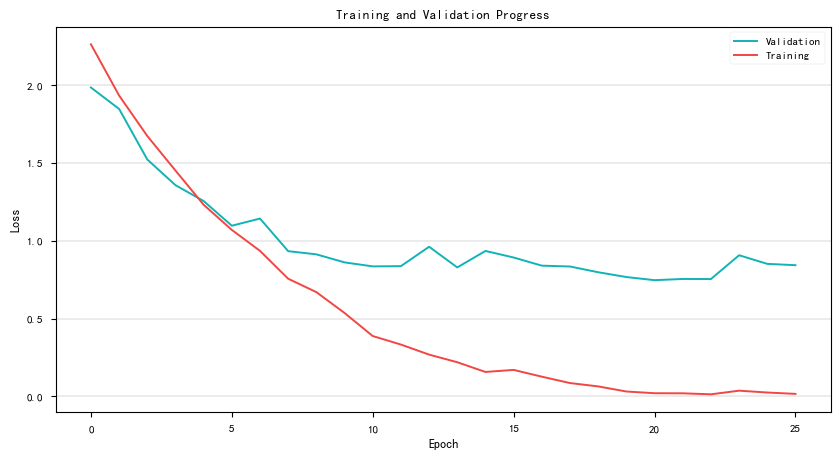

In [29]:
# 构造参数字典
params3 = {
    "train_args": {
        "model_name": TimesNet,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 50,
        "learning_rate": 0.001,
        "loss": nn.CrossEntropyLoss(),
        "patience": 5,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/TimesNet_audio_C",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 28,
        'top_k': 5,
        'd_model': 128,
        'num_kernels': 6,
        'd_ff': 256,
        'dropout': 0.1,
        'e_layers': 2,
        'enc_in': 40,
        'num_class': 12,
    },
}
model = train(**params3)

## 模型预测